# Data (Alina Shimizu - Jozi)

In [101]:
!pip install ucimlrepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

#TASK 1 - Acquire, Preprocess and Analyze Data
#Dataset 1 heart disease (binary)

#fetch dataset
heart_disease = fetch_ucirepo(id=45)

#data as pd data frame
X = heart_disease.data.features
y = heart_disease.data.targets


#Option 1 - Drop missing values
X_clean = X.dropna() # we could also do average here and compare
y_clean = y.loc[X_clean.index]
#print(X_clean.shape)
#print(y_clean.shape)

#Option 2 - Fill with average
X_clean2 = X.fillna(X.mean())
#print(X_clean)
y_clean2 = y
#y can stay the same because there are no missing target values

#duplicate check
duplicates = X_clean.duplicated().sum()
#print(duplicates)

#Compute basic statistics
pos_indices = y_clean[y_clean['num'].isin([1, 2, 3, 4])].index
#print(pos_indices)
X_pos = X_clean.loc[pos_indices]
mean_pos = X_pos.mean()
#print(f"Means of features for people with heart disease\n{mean_pos}")
X_pos.describe()

neg_indices = y_clean[y_clean['num'] == 0].index
#print(neg_indices)
X_neg = X_clean.loc[neg_indices]
mean_neg = X_neg.mean()
#print(f"Means of features for people without heart disease\n{mean_neg}")
#X_neg.describe()

#Rank mean squared difference
mean_sqd_diff = (mean_pos - mean_neg) ** 2
msd_ranked = mean_sqd_diff.sort_values(ascending=False)
#print("Mean squared differnce of features for people with and without heart disease")
#print(msd_ranked)

#***DATASET 2 - Penguin Dataset for Multi-Class***
data = pd.read_csv('penguins_size.csv')


#Mapping here to change sex into a numerical variable 
X_penguin = data.drop(columns=['species', 'island'])
X_penguin['sex'] = X_penguin['sex'].map({'MALE': 1, 'FEMALE': 0})
y_penguin = data['species']


#Option 1 - Drop na rows 
X_penguin_clean = X_penguin.copy().dropna() 
y_penguin_clean = y_penguin.copy().loc[X_penguin_clean.index]
#print(y_penguin_clean.head())
#print(X_penguin_clean.head())

#Option 2 - Fill NA rows with average 
X_penguin_clean2 = X_penguin.copy()
numeric_columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm']
X_penguin_clean2[numeric_columns] = X_penguin_clean2[numeric_columns].fillna(X_penguin_clean2[numeric_columns].mean())
#handle sex column differently 
X_penguin_clean2['sex'] = X_penguin_clean2['sex'].fillna(X_penguin_clean2['sex'].mode().iloc[0])

y_penguin_clean2 = y_penguin.copy()
#y can stay the same because there are no missing target values

#other cleaning processes to be completed: remove duplicates, outliers, invalid values
#X_penguin_clean2.boxplot(column=numeric_columns)
#plt.show()
#this was hard to visualize since the numbers are on very different scales, but could go back and normalize 

#checked for duplicates, all False and all values valid 

#Compute means of each feature in each species group: Need to concat back into one df first 
cleaned_penguin_data = pd.concat([X_penguin_clean2, y_penguin_clean2], axis=1)

#helper function for multi-class stats 
def penguin_stats(group):
    stats = group.mean(numeric_only=True) 
    stats['sex'] = group['sex'].mode()[0] 
    return stats

grouped_stats = cleaned_penguin_data.groupby('species').apply(penguin_stats)

print(grouped_stats)

#compute all the squared differences 
squared_differences = {}

#sum of squared differences, should also maybe do pairwise differences 

for col in X_penguin_clean2.columns:
    means = grouped_stats[col]
    diff_sum = 0
    for i in range(len(means)):
        for j in range(i + 1, len(means)):
            diff_sum += (means.iloc[i] - means.iloc[j]) ** 2 #squared difference between group means
    squared_differences[col] = diff_sum

rank_features = sorted(squared_differences.items(), key=lambda x: x[1], reverse=True)


X_clean = X_clean[['thalach', 'chol', 'trestbps', 'age', 'thal']]

y_clean = y_clean.replace({1: 1, 2: 1, 3: 1, 4: 1})


print("Ranked Features")
for feature, score in rank_features:
    print(f"{feature}: {score}")

           culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  \
species                                                                        
Adelie            38.825144        18.338495         190.025758  3700.662252   
Chinstrap         48.833824        18.420588         195.823529  3733.088235   
Gentoo            47.475983        14.999606         217.055768  5076.016260   

           sex  
species         
Adelie     1.0  
Chinstrap  0.0  
Gentoo     1.0  
Ranked Features
body_mass_g: 3696105.7731082886
flipper_length_mm: 1215.043533033442
culmen_length_mm: 176.8544064102005
culmen_depth_mm: 22.85803270042596
sex: 2.0


/var/folders/zv/s9xt0_f507n54r3q6rl1x2bm0000gn/T/ipykernel_14306/4245790640.py:97: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_stats = cleaned_penguin_data.groupby('species').apply(penguin_stats)


# Decision Tree Setup

In [102]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
np.random.seed(1234)

class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    # Stores the data indices in the region defined by this node
        self.left = None                                    # Stores the left child of the node
        self.right = None                                   # Stores the right child of the node
        self.split_feature = None                           # The feature for the split at this node
        self.split_value = None                             # The value of the feature for the split at this node
        if parent:
            self.depth = parent.depth + 1                   # Obtain the depth of the node by adding one to depth of the parent
            self.num_classes = parent.num_classes           # Copies the num_classes from the parent
            self.data = parent.data                         # Copies the data from the parent
            self.labels = parent.labels                     # Copies the labels from the parent
            # Align indices with .loc instead of .iloc
            selected_labels = self.labels.loc[data_indices].values.flatten().astype(int)
            class_prob = np.bincount(selected_labels, minlength=self.num_classes)  # Count frequency of labels in this node's region
            self.class_prob = class_prob / np.sum(class_prob)  # Compute class probabilities

#########################################################################################################
#########################################################################################################
#GREEDY NODE SPLIT
#########################################################################################################
#########################################################################################################

def greedy_test(node, cost_fn):
    # Initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    
    # Iterate over features
    for f in range(num_features):
        # Get the data for the f-th feature
        feature_name = node.data.columns[f]
        data_f = node.data.loc[node.data_indices, feature_name]
        
        # Sort the values for the current feature
        data_sorted = data_f.sort_values()
        
        # Generate test candidates (averages of consecutive sorted values)
        test_candidates = (data_sorted.values[1:] + data_sorted.values[:-1]) / 2.0
        
        # Iterate over test candidates
        for test in test_candidates:
            # Split the indices using the test value
            left_indices = data_f.index[data_f <= test]
            right_indices = data_f.index[data_f > test]
            
            # Skip invalid splits
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            
            # Compute costs for left and right splits
            left_cost = cost_fn(node.labels.loc[left_indices].values)
            right_cost = cost_fn(node.labels.loc[right_indices].values)
            num_left, num_right = len(left_indices), len(right_indices)
            
            # Calculate weighted combined cost
            cost = (num_left * left_cost + num_right * right_cost) / num_instances
            
            # Update if a lower cost is found
            if cost < best_cost:
                best_cost = cost
                best_feature = feature_name
                best_value = test
    
    return best_cost, best_feature, best_value


#########################################################################################################
#########################################################################################################
#COST FUNCTIONS
#########################################################################################################
#########################################################################################################


def cost_misclassification(labels):
    # Ensure labels are a 1D NumPy array of integers
    labels = np.asarray(labels).flatten().astype(int)
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    return 1 - np.max(class_probs)

def cost_entropy(labels):
    # Ensure labels are a 1D NumPy array of integers
    labels = np.asarray(labels).flatten().astype(int)
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    class_probs = class_probs[class_probs > 0]  # Remove 0 probabilities to avoid log(0)
    return -np.sum(class_probs * np.log2(class_probs))  # Expression for entropy: -Σ p(x) log2[p(x)]

def cost_gini_index(labels):
    # Ensure labels are a 1D NumPy array of integers
    labels = np.asarray(labels).flatten().astype(int)
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    return 1 - np.sum(np.square(class_probs))  # Expression for Gini index: 1 - Σ p(x)^2

#########################################################################################################
#########################################################################################################
#CLASSIFIER
#########################################################################################################
#########################################################################################################

class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination 
        self.root = None                #stores the root of the decision tree 
        self.cost_fn = cost_fn          #stores the cost function of the decision tree 
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        
    def fit(self, data, labels):
        pass                            #pass in python 3 means nothing happens and the method here is empty
    
    def predict(self, data_test):
        pass

#########################################################################################################
#########################################################################################################
#FIT
#########################################################################################################
#########################################################################################################

    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        if self.num_classes is None:
            self.num_classes = len(np.unique(labels))
        # Initialize the root of the decision tree
        self.root = Node(data.index, None)  # Use DataFrame index
        self.root.data = data
        self.root.labels = labels
        self.root.num_classes = self.num_classes
        self.root.depth = 0
        # Recursively build the rest of the tree
        self._fit_tree(self.root)
        return self

    def _fit_tree(self, node):
        # Termination condition: leaf node
        if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
            return
        # Greedily select the best test by minimizing the cost
        cost, split_feature, split_value = greedy_test(node, self.cost_fn)
        # If the cost is infinity, terminate
        if np.isinf(cost):
            return
        # Store the split feature and value
        node.split_feature = split_feature
        node.split_value = split_value
        # Get a boolean array indicating which data indices are in the left split
        test = node.data.loc[node.data_indices, split_feature] <= split_value
        # Define left and right child nodes
        left_indices = node.data_indices[test]
        right_indices = node.data_indices[~test]
        left = Node(left_indices, node)
        right = Node(right_indices, node)
        # Recursive call to _fit_tree()
        self._fit_tree(left)
        self._fit_tree(right)
        # Assign the left and right child to the current node
        node.left = left
        node.right = right

#########################################################################################################
#########################################################################################################
#PREDICT
#########################################################################################################
#########################################################################################################

    def predict(self, data_test):
        class_probs = np.zeros((data_test.shape[0], self.num_classes))
        for n, (_, x) in enumerate(data_test.iterrows()):  # Iterate over rows in the DataFrame
            node = self.root
            # Traverse the tree to find the appropriate leaf
            while node.left:
                if x[node.split_feature] <= node.split_value:
                    node = node.left
                else:
                    node = node.right
            # Assign the class probabilities from the leaf node
            class_probs[n, :] = node.class_prob
    
        return class_probs

    def evaluate_acc(self, probs_test):
        # Make predictions
        y_pred = np.argmax(probs_test, axis=1)
        
        # Convert y_train and y_test to 1D arrays
        y_train_1d = y_train.squeeze()  # Convert to Series if it's a single-column DataFrame
        y_train_1d = y_train_1d.to_numpy() if isinstance(y_train_1d, pd.Series) else y_train_1d
        
        y_test_1d = y_test.squeeze()  # Convert to Series if it's a single-column DataFrame
        y_test_1d = y_test_1d.to_numpy() if isinstance(y_test_1d, pd.Series) else y_test_1d
    
        accuracy = np.sum(y_pred == y_test_1d) / y_test_1d.shape[0]
        print(f'Accuracy is {accuracy * 100:.2f}%')

# Experiments

## Functions

In [103]:
def DT_train_test_split(X,Y):
    #load data
    x = X
    y = Y
    # Dataset characteristics
    num_instances, num_features = x.shape
    num_classes = y.nunique()  # Number of unique classes
    
    # Randomization
    inds = np.random.permutation(num_instances)
    
    # Train-Test Split
    x_train, y_train = x.iloc[inds[:100]], y.iloc[inds[:100]]
    x_test, y_test = x.iloc[inds[100:]], y.iloc[inds[100:]]
    return x_train, y_train, x_test, y_test

def DT_train_evaluate(cost, x_train, y_train):
    # Train the Decision Tree
    tree = DecisionTree(max_depth=20, cost_fn = cost)
    probs_test = tree.fit(x_train, y_train).predict(x_test)
    
    tree.evaluate_acc(probs_test)


def DT_experiment_max_depth(x_train,y_train):
    # Further split the training data into 50% training and 50% validation
    X_train_tr = x_train.iloc[:50]
    y_train_tr = y_train.iloc[:50]
    X_train_va = x_train.iloc[50:]
    y_train_va = y_train.iloc[50:]
    
    model_choices = []
    train_acc = []
    valid_acc = []
    
    n_train = y_train_tr.shape[0]
    n_valid = y_train_va.shape[0]

    for k in range(1, 11):
        # Create a DecisionTree object with depth k
        dt = DecisionTree(max_depth=k)
    
        # Train on training subset and calculate training accuracy
        y_train_tr_prob = dt.fit(X_train_tr, y_train_tr).predict(X_train_tr)
        y_train_tr_pred = np.argmax(y_train_tr_prob, axis=-1)
        acc_tr = np.sum(y_train_tr_pred == y_train_tr.squeeze().to_numpy()) / n_train
    
        # Validate on validation subset and calculate validation accuracy
        y_train_va_prob = dt.fit(X_train_tr, y_train_tr).predict(X_train_va)
        y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
        acc_va = np.sum(y_train_va_pred == y_train_va.squeeze().to_numpy()) / n_valid
    
        # Store results
        model_choices.append(k)
        train_acc.append(acc_tr)
        valid_acc.append(acc_va)

    # Use the best depth to predict test data
    best_depth = model_choices[valid_acc.index(max(valid_acc))]
    dt = DecisionTree(max_depth=best_depth)
    
    # Train on full training set and predict on test set
    y_test_prob = dt.fit(x_train, y_train).predict(x_test)
    y_test_pred = np.argmax(y_test_prob, axis=-1)
    test_accuracy = np.sum(y_test_pred == y_test.squeeze().to_numpy()) / y_test.shape[0]
    
    print(f'Best depth = {best_depth}, test accuracy = {test_accuracy:.2f}')
    
    # Plot training, validation, and test accuracies
    plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
    plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
    plt.scatter(best_depth, test_accuracy, marker='*', color='red', label='testing')
    plt.xlabel("Tree Depth")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    
    plt.show()
    

## Heart Disease

Accuracy is 63.96%
Running Max Depth experiment (splitting data into train, validation, test)
Best depth = 3, test accuracy = 0.80


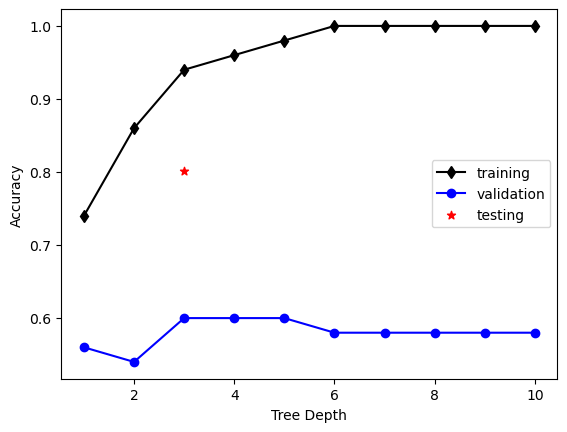

In [104]:
x_train, y_train, x_test, y_test = DT_train_test_split(X_clean,y_clean)
DT_train_evaluate(cost_gini_index, x_train, y_train)
print('Running Max Depth experiment (splitting data into train, validation, test)')
DT_experiment_max_depth(x_train,y_train)

## Penguins

In [105]:
# # Encode labels as integers
label_mapping = {label: idx for idx, label in enumerate(y_penguin_clean.unique())}
y_encoded = y_penguin_clean.map(label_mapping)

Accuracy is 93.56%
Running Max Depth experiment (splitting data into train, validation, test)
Best depth = 2, test accuracy = 0.96


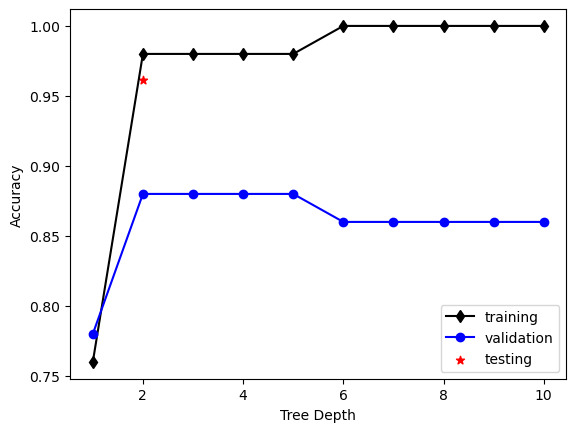

In [106]:
x_train, y_train, x_test, y_test = DT_train_test_split(X_penguin_clean,y_encoded)
DT_train_evaluate(cost_gini_index, x_train, y_train)
print('Running Max Depth experiment (splitting data into train, validation, test)')
DT_experiment_max_depth(x_train,y_train)